## Time Series modelling


In [2]:
# import packages
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [14]:
# transpose the data frame and drop the unwanted columns

kpi_path = 'C:/Users/ywa/Documents/Data/KPI Table/KPI.csv'

kpi_trans = pd.read_csv(kpi_path, sep = ',', dtype = 'string').drop(['Referenz', 'KPI'], axis = 1).transpose().reset_index()

kpi_trans.columns = kpi_trans.iloc[0]

kpi_trans = kpi_trans.drop(index = [0], axis = 0)

kpi_trans['Date'] = kpi_trans['Short Name']

kpi = kpi_trans.drop(['Short Name', 'Video Views Youtube', 'Unique Viewers Lernvideos (90 days)', 'Hörer Dr med', 'Hörer Celonis', 'Hörer Journalismus', 'Hörer KI kapiert', 'Lernende erreicht'], axis = 1)

kpi['Date'] = pd.to_datetime(kpi['Date'], format = '%d.%m.%Y')

kpi = kpi.set_index('Date', drop = True).sort_index()

In [7]:
# row-wise cleaning
#kpi['Visitors Portal total'] = kpi['Visitors Portal total'].where(~kpi['Visitors Portal total'].str.contains(','), kpi['Visitors Portal total'].str.replace(',', ''))
#kpi['SLDF'] = kpi['SLDF'].where(~kpi['SLDF'].str.contains(r'\D'), kpi['SLDF'].str.replace(r'^\s*(\d+).*', r'\1', regex = True))


In [15]:
# with function
def pattern_eliminator(df): 
    for col in df.columns:
        if df[col].dtype == 'string':            
            df[col] = df[col].where(~df[col].str.contains(','), df[col].str.replace(',', ''))
            df[col] = df[col].where(~df[col].str.contains(r'\D'), df[col].str.replace(r'^\s*(\d+).*', r'\1', regex=True))
        else: 
            df[col] = df[col]
    return df

def float_maker(df):
    for col in df.columns:
        if df[col].dtype == 'string':
            df[col] = df[col].astype('float64')
        else:
            df[col] = df[col]
    return df


kpi = pattern_eliminator(kpi)
 
kpi = float_maker(kpi)


In [16]:
kpi.isnull().sum()

0
Visitors Portal total       12
SLDF                         0
User Portal                  0
User LMS                     0
Total enrollments            0
CoP                         14
RoA                          0
User Moodle                 25
Total enrollments Moodle    29
CoP Moodle                  25
RoA Moodle                  25
dtype: int64

In [17]:
# impute missing values
visitors_portal = kpi['Visitors Portal total'].dropna() # stationary
CoP = kpi['CoP']['2022-05-01': '2025-01-01']
CoP = CoP.fillna(CoP.rolling(window=3, min_periods=1).mean())
user_moodle = kpi['User Moodle'].dropna() #stationary
enrol_moodle = kpi['Total enrollments Moodle'].dropna()
CoP_moodle = kpi['CoP Moodle'].dropna()
RoA_moodle = kpi['RoA Moodle'].dropna()

#kpi

In [19]:
# save table
#kpi.to_csv('C:/Users/ywa/Documents/Data/KPI Table/clean_KPI.csv')
#kpi.to_excel('C:/Users/ywa/Documents/Data/KPI Table/clean_KPI.xlsx')

In [23]:
kpi[['User Portal', 'User Moodle', 'Total enrollments Moodle']].tail(3)

,User Portal,User Moodle,Total enrollments Moodle
Date,,,
2025-03-01,83089.0,32657.0,40321.0
2025-04-01,87315.0,36136.0,46784.0
2025-05-01,91512.0,40853.0,53053.0


### here to start the modelling for variables
* Visitors portal total

In [15]:
# Testing stationarity
def check_stationarity_diff(df, max_d):
    dictionary = {'col' : [],  'order' : []}
    for col in df.columns:
        for d in range(1, max_d + 1):
            col_diff = df[col].dropna().diff(d).dropna()
            diff_res = adfuller(col_diff)
            if diff_res[1] < 0.05:
                print(f'for difference {col} with order {d}, the p-value is {diff_res[1]}, the series is stationary')
                dictionary['col'].append(col)
                dictionary['order'].append(d)
                
                #plt.figure()
                #plt.plot(col_diff)
                #plt.title(f'Stationary Series of {col} at Order {d}')
                #plt.show()
                
                break
    return pd.DataFrame(dictionary)
        #print(f'for difference {col}, the p-value is {diff_res[1]}, a p-value larger than alpha means the series is non-stationary')
        

#kpi['Visitors Portal total'].plot()

# Transforming stationarity
vis_portal_diff = (kpi['Visitors Portal total'].dropna().diff().dropna())
vis_portal_diff_res = adfuller(vis_portal_diff)
print(f'the p-value is {vis_portal_diff_res[1]}, a p-value larger than alpha means the series is non-stationary')


the p-value is 0.23071035800611894, a p-value larger than alpha means the series is non-stationary


* SLDF

In [16]:
# testing for all cols
stationary_cols = check_stationarity_diff(kpi, max_d = 10)

stationary_cols.head()

for difference Visitors Portal total with order 6, the p-value is 0.029306514516904508, the series is stationary
for difference SLDF with order 1, the p-value is 1.596631741166994e-05, the series is stationary
for difference User LMS with order 6, the p-value is 0.043208748816685, the series is stationary
for difference Total enrollments with order 6, the p-value is 0.049204004099251665, the series is stationary
for difference User Moodle with order 1, the p-value is 4.985772013598105e-13, the series is stationary


,col,order
0,Visitors Portal total,6
1,SLDF,1
2,User LMS,6
3,Total enrollments,6
4,User Moodle,1


C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


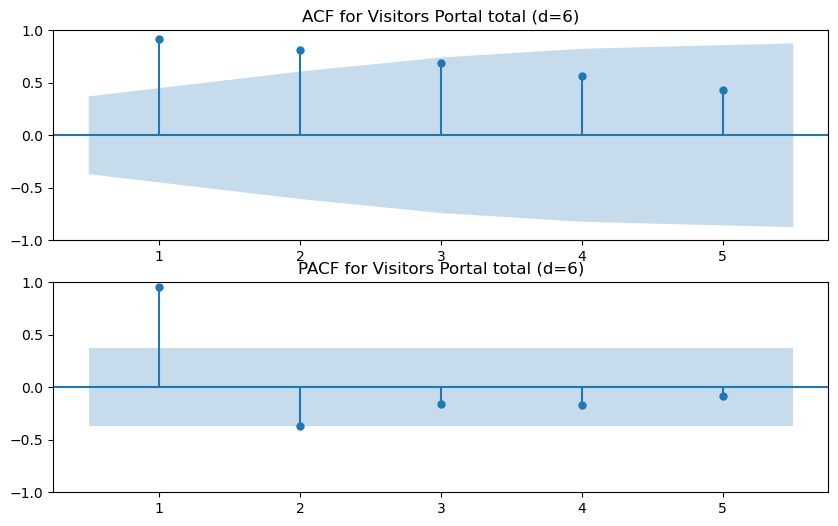

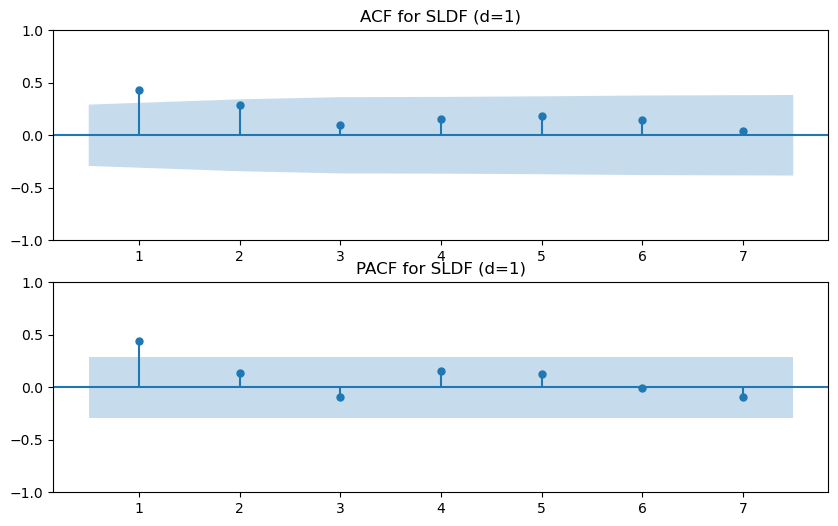

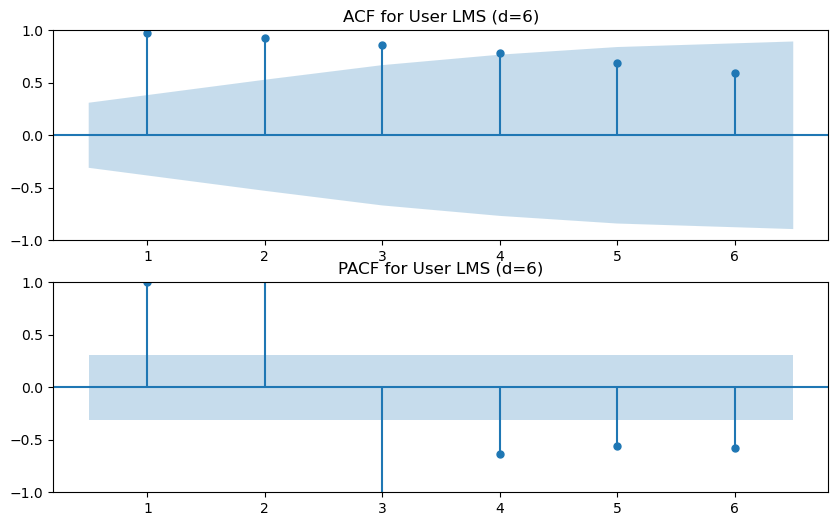

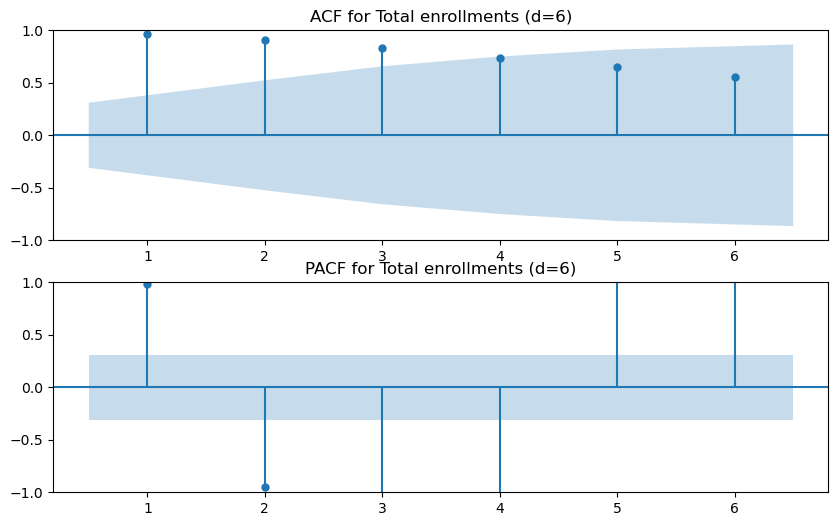

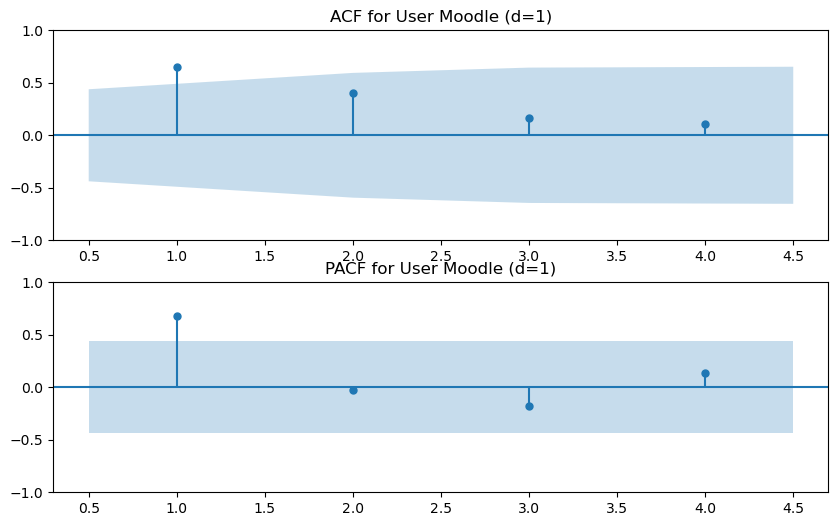

In [17]:
# Checking p and q orders

def acf_pacf_plot(df, df_stationary_test):
    for cols, d in zip(df_stationary_test['col'], df_stationary_test['order']):
        ts = (df[cols].dropna()).diff(d).dropna()
        lag = np.sqrt(len(ts)).round(0)
        fig,(ax1, ax2) = plt.subplots(2, 1, figsize = (10, 6))
        try: 
            plot_acf(ts, lags = lag, zero = False, ax = ax1)
            plot_pacf(ts, lags = lag, zero = False, ax = ax2)
            ax1.set_title(f'ACF for {cols} (d={d})')
            ax2.set_title(f'PACF for {cols} (d={d})')
            plt.show()
        except: 
            print(f'{cols} column cannot handle large lags!')
    
acf_pacf_plot(kpi, stationary_cols)


Based on the output, the order of the ARIMA model:
* Visitor Portal total: ARIMA(1, 6, 0)
* SLDF: ARIMA(p, 1, q)
* User LMS: ARIMA(p, 6, q)
* Total enrollments: ARIMA(p, 6, q) 
* User Moodle: ARIMA(1, 1, 0)

In [18]:
# building models for the sig columns
# for Visitor Portal total
visitor_portal_model = ARIMA(visitors_portal, order = (1, 6, 0))
res_visitor_portal = visitor_portal_model.fit()

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [19]:
# for User Moodle
user_moodle_model = ARIMA(user_moodle, order = (1, 1, 0))
res_user_moodle = user_moodle_model.fit()

C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\ywa\AppData\Local\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


### trying out with log / sqrt transformation for stationarity

Exclude the columns from the hpi. We have:
* Visitors Portal total
* SLDF
* User Portal              
* User LMS --> hpi                   
* Total enrollments  --> hpi          
* CoP --> hpi                    
* RoA --> hpi                 
* User Moodle             
* Total enrollments Moodle    
* CoP Moodle                  
* RoA Moodle   

In [20]:
# log transformation of the dataframe
interest_kpi = kpi[['Visitors Portal total', 'SLDF', 'User Portal', 'User Moodle', 'Total enrollments Moodle', 'CoP Moodle', 'RoA Moodle']]

# remove 0 values in the CoP and RoA columns
interest_kpi = interest_kpi.replace(0, np.nan)

for col in interest_kpi.columns:
    col_log = np.log(interest_kpi[col].dropna())
    log_res = adfuller(col_log)
    if log_res[1] < 0.05:
        print(f'for the log transformation of {col}, the p-value is {log_res[1]}, the series is stationary')
    else:
        print(f'for the log transformation of {col}, the p-value is {log_res[1]}, the series is not stationary')
        

for the log transformation of Visitors Portal total, the p-value is 0.21720656879494782, the series is not stationary
for the log transformation of SLDF, the p-value is 3.634287508458141e-10, the series is stationary
for the log transformation of User Portal, the p-value is 0.9113987524267817, the series is not stationary
for the log transformation of User Moodle, the p-value is 1.2095644403882313e-14, the series is stationary
for the log transformation of Total enrollments Moodle, the p-value is 0.9986764574076703, the series is not stationary
for the log transformation of CoP Moodle, the p-value is 0.18951738625064862, the series is not stationary
for the log transformation of RoA Moodle, the p-value is 0.9990375125743988, the series is not stationary


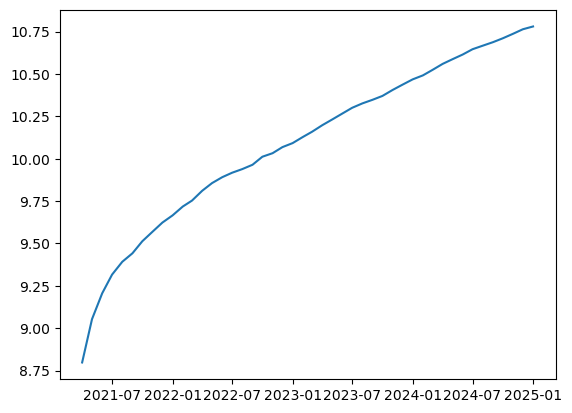

In [21]:
# SLDF
plt.plot(np.log(interest_kpi['SLDF'].dropna()))

# User Moodle

In [30]:
# Model predictions:
# Visitor portal total
def plot_forecast(origin_ts, pred_ts, title):
    plt.figure(figsize = (10, 6))
    plt.plot(origin_ts, label = 'original', color = '#3A2A78')
    plt.plot(pred_ts, label = 'prediction', color = '#2891BA', linestyle = 'dotted' )
    plt.title(title)
    plt.legend()
    plt.show()
    
    
pred_visitor_portal = res_visitor_portal.forecast(steps = 12)
plt.figure(figsize = (10, 6))
plt.plot(visitors_portal, label = 'original', color = '#3A2A78')
plt.plot(pred_visitor_portal, label = 'prediction', color = '#2891BA', linestyle = 'dotted' )
plt.title('Forecast Total Portal Visitor')
plt.legend()
plt.show()

print(pred_visitor_portal)

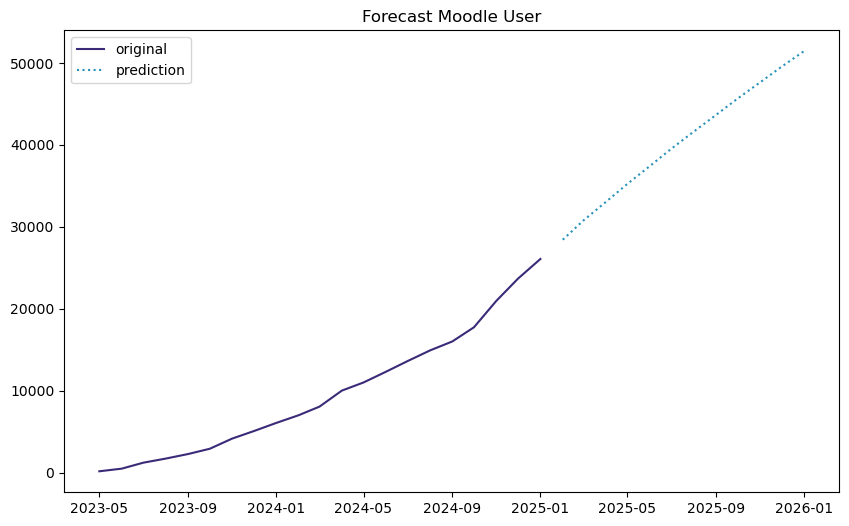

2025-02-01    28418.963142
2025-03-01    30723.812057
2025-04-01    32983.451276
2025-05-01    35198.767589
2025-06-01    37370.630392
2025-07-01    39499.892026
2025-08-01    41587.388116
2025-09-01    43633.937894
2025-10-01    45640.344523
2025-11-01    47607.395412
2025-12-01    49535.862527
2026-01-01    51426.502689
Freq: MS, Name: predicted_mean, dtype: float64


<Axes: >

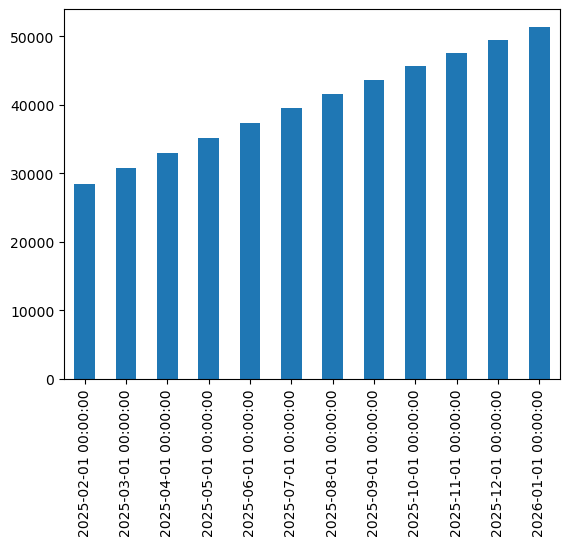

In [36]:
# User Moodle 
pred_user_moodle = res_user_moodle.forecast(steps = 12)
plot_forecast(user_moodle, pred_user_moodle, 'Forecast Moodle User')

print(pred_user_moodle)
pred_user_moodle.plot.bar()

## Moving Agerage method

Predict the value based on the same data point from the last year. <plotting / dashed-line>
Function?

In [25]:
# base code
#user_portal_pct = kpi['User Portal'].pct_change().dropna()

# project JAN: get vars
#rate_24 = user_portal_pct['2024-02-01']
#rate_23 = user_portal_pct['2023-02-01']
#rate_23
#mean_rate_jan = (rate_24 + rate_23)/2

#rate_24_dec = user_portal_pct['2024-12-01']
#rate_24_nov = user_portal_pct['2024-11-01']
#rate_24_oct = user_portal_pct['2024-10-01']
#mean_rate_last_month = (rate_24_dec + rate_24_nov + rate_24_oct) / 3

# predict jan
#kpi['User Portal']['2024-12-01'] + (mean_rate_jan * kpi['User Portal']['2024-12-01']) * 0.7 + (mean_rate_last_month * kpi['User Portal']['2024-12-01']) * 0.3


# base code
user_portal_pct = kpi['User Portal'].pct_change().dropna()

# project JUNE: get vars
rate_24 = user_portal_pct['2024-06-01']
rate_23 = user_portal_pct['2023-06-01']
rate_23
mean_rate_june = (rate_24 + rate_23)/2

rate_24_may = user_portal_pct['2024-05-01']
rate_24_april = user_portal_pct['2024-04-01']
rate_24_march = user_portal_pct['2024-03-01']
mean_rate_last_month = (rate_24_may + rate_24_april + rate_24_march) / 3

# predict jan
kpi['User Portal']['2025-05-01'] + (mean_rate_jan * kpi['User Portal']['2025-05-01']) * 0.7 + (mean_rate_last_month * kpi['User Portal']['2025-05-01']) * 0.3

96820.5040617436

In [27]:
# Writing function of moving average
def moving_average(series, date_of_interest, span, w1, w2):
    '''
    Computes a weighted moving average prediction based on historical percentage changes.

    This function calculates the expected value of a given time series at a specific 
    date based on its historical percentage changes from previous years and months.

    Parameters:
    ----------
    series : pd.Series
        A pandas Series representing the time series data. The index should be 
        datetime-like (YYYY-MM-DD format), and the values should be numerical.

    date_of_interest : str
        A string representing the date (YYYY-MM-DD) for which the prediction is made.

    span : int
        The number of years to look back for historical trends.

    w1 : float
        The weight applied to the historical yearly percentage change.

    w2 : float
        The weight applied to the historical monthly percentage change.

    Returns:
    -------
    float
        The predicted value of the series for the given `date_of_interest`.

    Notes:
    ------
    - The function calculates percentage changes in the series.
    - It considers both past years' trends and recent months' trends.
    - The prediction is computed using a weighted sum of these historical trends.
    '''
    series_pct = series.pct_change().dropna()
    date_of_interest = datetime.strptime(date_of_interest,'%Y-%m-%d').date()
    previous_month = (date_of_interest - relativedelta(months = 1)).strftime('%Y-%m-%d')
    #year_of_interest = date_of_interest.year
    #month_of_interest = date_of_interest.month
    year_indicies = []
    month_indicies = []
    #indexing rate based on the given date
    for y in range(1, span + 1):
        date_year = (date_of_interest - relativedelta(years = y) + relativedelta(months = 1)).strftime('%Y-%m-%d')
        year_indicies.append(date_year)
        
    for m in range(1, 4, 1):
        date_month = (date_of_interest - relativedelta(months = m)).strftime('%Y-%m-%d')
        month_indicies.append(date_month)
    
    # calculation
    rate_year = series_pct[year_indicies]
    rate_month = series_pct[month_indicies]
    mean_rate_year = rate_year.mean()
    mean_rate_month = rate_month.mean()
    pred_value = series[previous_month] + mean_rate_year * series[previous_month] * w1 + mean_rate_month * series[previous_month] * w2
    #print(series[previous_month])
    return pred_value

#testing
test = moving_average(kpi['User Portal'], '2025-06-01', span = 2, w1 = 0.7, w2 = 0.3)
test


96263.38705265125

#### Dynamic weights
* For semester-start months (April, October): w1 = 0.8, w2 = 0.25
* For the semester break months (July, August, September, Febuary, March): w1 = 0.8, w2 = 0.25
* For the regular months: w1 = 0.6 , w2 = 0.4 

In [28]:
# Create prediction dictionary

#pred_moving_average = pd.DataFrame({'date': ['2025-02-01', '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01', '2026-01-01' ], 'values' : [0] * 12})

pred_moving_average = pd.DataFrame({'date': ['2025-06-01', '2025-07-01', '2025-08-01', '2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01'], 'values' : [0] * 7})

# prepare dataframe based on the existing data
ma_user_portal = pd.DataFrame(kpi['User Portal'])
ma_visitors_portal = pd.DataFrame(visitors_portal)
ma_moodle_user = pd.DataFrame(user_moodle)
ma_sldf = pd.DataFrame(kpi['SLDF'])
ma_total_enrolments_moodle = pd.DataFrame(kpi['Total enrollments Moodle'])
ma_cop_moodle = pd.DataFrame(kpi['CoP Moodle'])
ma_roa_moodle = pd.DataFrame(kpi['RoA Moodle'])


            Visitors Portal total
Date                             
2025-05-01           1.961822e+06
2025-06-01           2.064381e+06
2025-07-01           2.168344e+06
2025-08-01           2.262753e+06
2025-09-01           2.378238e+06
2025-10-01           2.508515e+06
2025-11-01           2.636813e+06
2025-12-01           2.764608e+06


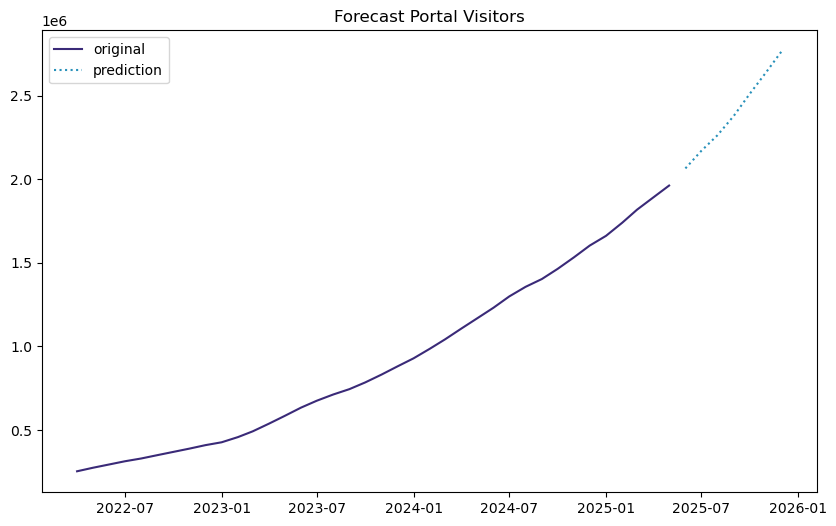

<Axes: xlabel='Date'>

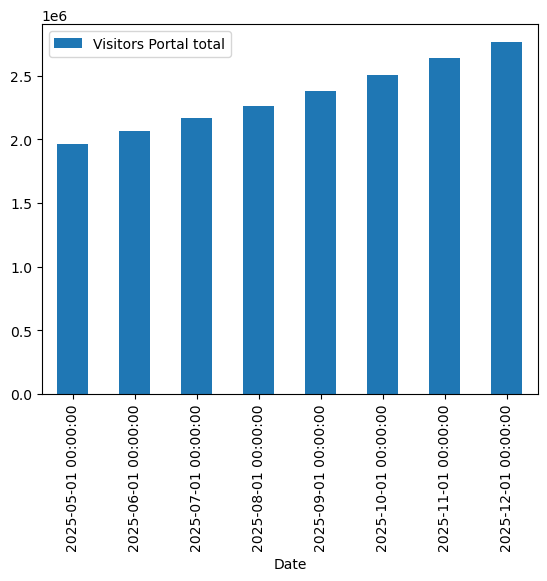

In [38]:
# predicting 

# Portal Visitor
for d in pred_moving_average['date']:    
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_visitors_portal['Visitors Portal total'], d, span = 2, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_visitors_portal['Visitors Portal total'], d, span = 2, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_visitors_portal['Visitors Portal total'], d, span = 2, w1 = 0.6, w2 = 0.4)
    ma_visitors_portal.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_visitors_portal.loc['2025-05-01' :])
    
plot_forecast(ma_visitors_portal.loc[: '2025-05-01'], ma_visitors_portal.loc['2025-06-01' :], 'Forecast Portal Visitors')

ma_visitors_portal.loc['2025-05-01' :].plot.bar()
    
# e+06 = 1 million (1,000,000)

              User Portal
Date                     
2025-05-01   91512.000000
2025-06-01   96225.719198
2025-07-01  101111.530883
2025-08-01  105623.682321
2025-09-01  110839.306528
2025-10-01  117792.697789
2025-11-01  124006.498211
2025-12-01  130636.546859


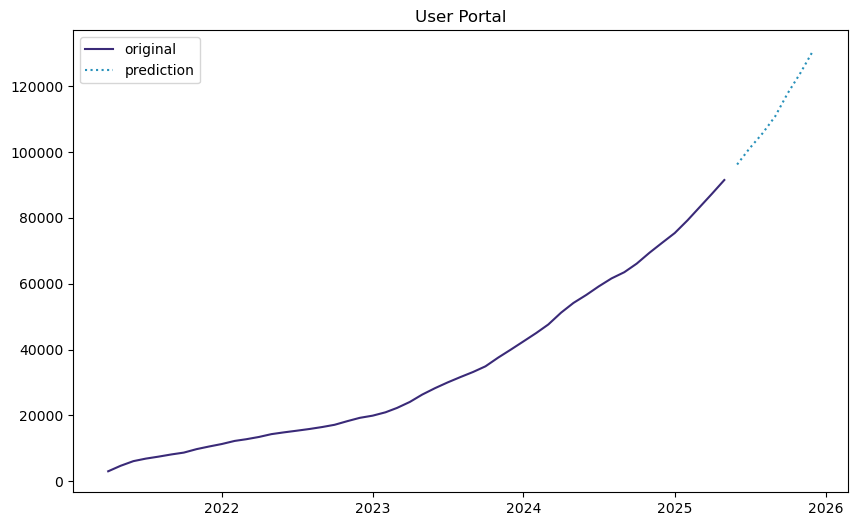

<Axes: xlabel='Date'>

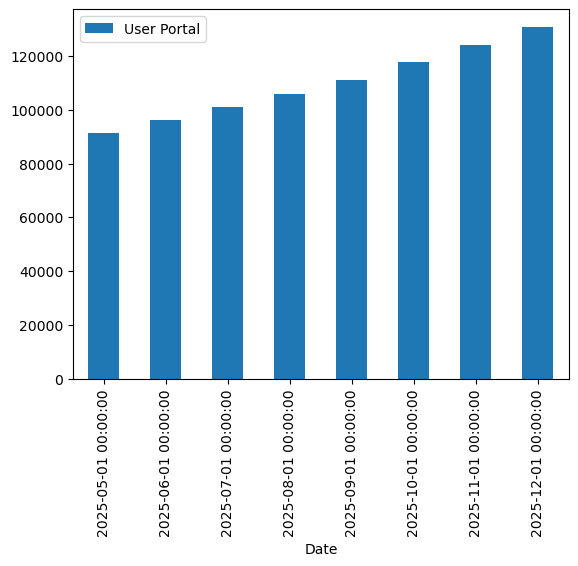

In [39]:
# Portal User
for d in pred_moving_average['date']:    
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_user_portal['User Portal'], d, span = 2, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_user_portal['User Portal'], d, span = 2, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_user_portal['User Portal'], d, span = 2, w1 = 0.6, w2 = 0.4)
    ma_user_portal.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_user_portal.loc['2025-05-01' :])
    
plot_forecast(ma_user_portal.loc[: '2025-05-01'], ma_user_portal.loc['2025-06-01' :], 'User Portal')

ma_user_portal.loc['2025-05-01' :].plot.bar()

             User Moodle
Date                    
2025-05-01  40853.000000
2025-06-01  45323.900234
2025-07-01  50089.830710
2025-08-01  54488.765157
2025-09-01  60577.940667
2025-10-01  70936.273278
2025-11-01  79948.691172
2025-12-01  89176.751650


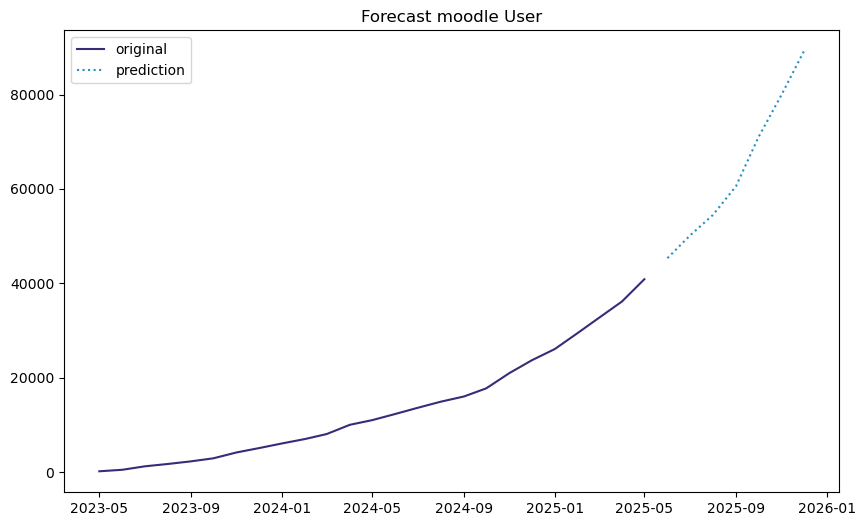

<Axes: xlabel='Date'>

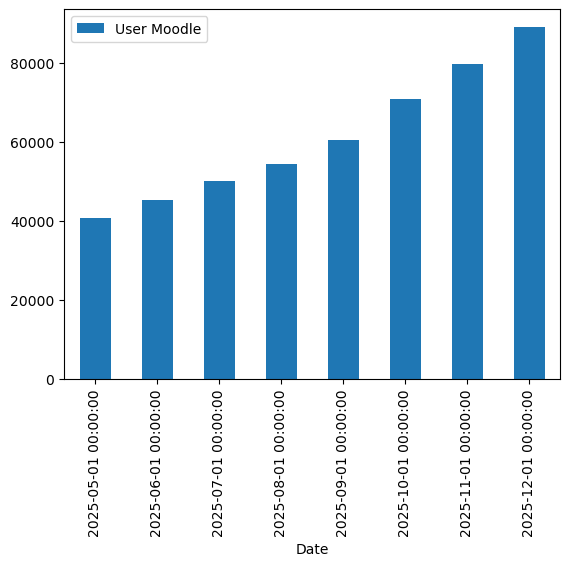

In [40]:
# Moodle User
for d in pred_moving_average['date']:    
    ma_moodle_user = ma_moodle_user.asfreq('MS')
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_moodle_user['User Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_moodle_user['User Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_moodle_user['User Moodle'], d, span = 1, w1 = 0.6, w2 = 0.4)
    ma_moodle_user.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
   
print(ma_moodle_user.loc['2025-05-01' :])
    
plot_forecast(ma_moodle_user.loc[: '2025-05-01'], ma_moodle_user.loc['2025-06-01' :], 'Forecast moodle User')

ma_moodle_user.loc['2025-05-01' :].plot.bar()


<Axes: >

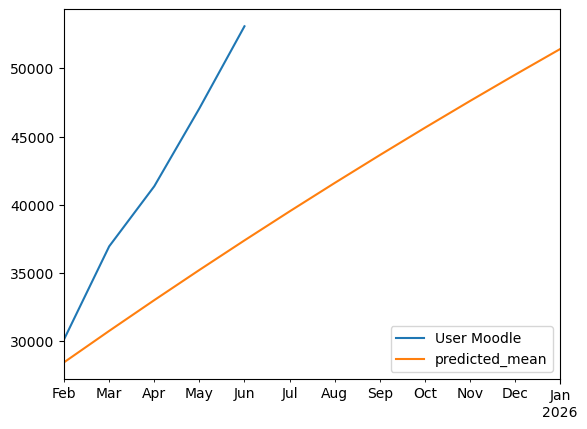

In [30]:
# comparing the prediction of two different methods
#compare_moodle_user = ma_moodle_user.loc['2025-02-01' :]

#compare_moodle_user = pd.concat([compare_moodle_user, pred_user_moodle], axis = 1)

#compare_moodle_user.plot(kind = 'line')

                    SLDF
Date                    
2025-05-01  52275.000000
2025-06-01  53690.967681
2025-07-01  54888.352541
2025-08-01  56110.902126
2025-09-01  57490.410037
2025-10-01  59056.351174
2025-11-01  60602.303521
2025-12-01  61834.139008


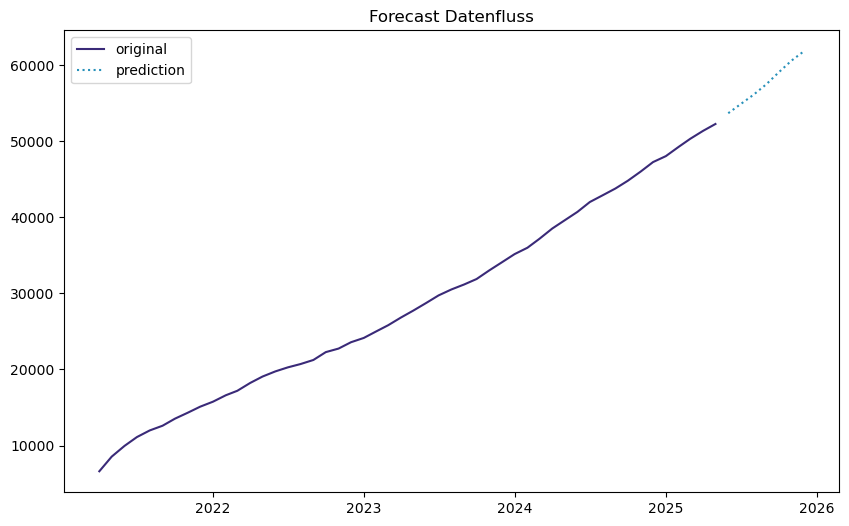

<Axes: xlabel='Date'>

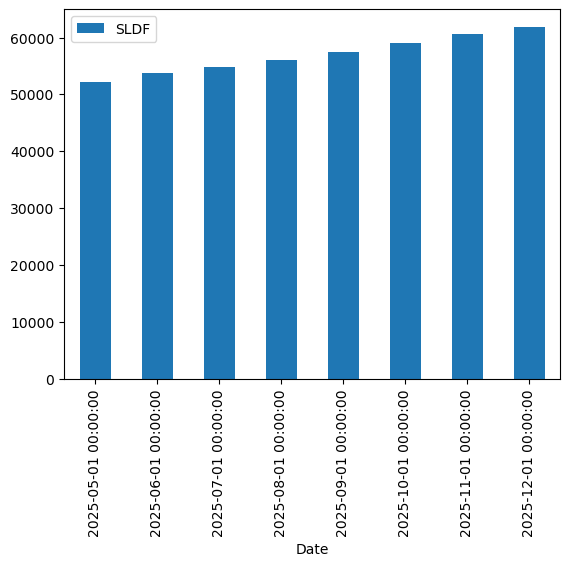

In [41]:
# SLDF
for d in pred_moving_average['date']:    
    ma_sldf = ma_sldf.asfreq('MS')
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_sldf['SLDF'], d, span = 1, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_sldf['SLDF'], d, span = 1, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_sldf['SLDF'], d, span = 1, w1 = 0.6, w2 = 0.4)
    ma_sldf.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_sldf.loc['2025-05-01' :])
    
plot_forecast(ma_sldf.loc[: '2025-05-01'], ma_sldf.loc['2025-06-01' :], 'Forecast Datenfluss')

ma_sldf.loc['2025-05-01' :].plot.bar()

            Total enrollments Moodle
Date                                
2025-05-01              53053.000000
2025-06-01              61290.557199
2025-07-01              71481.463391
2025-08-01              80919.273382
2025-09-01              95607.844933
2025-10-01             122639.104273
2025-11-01             148195.175827
2025-12-01             177017.028806


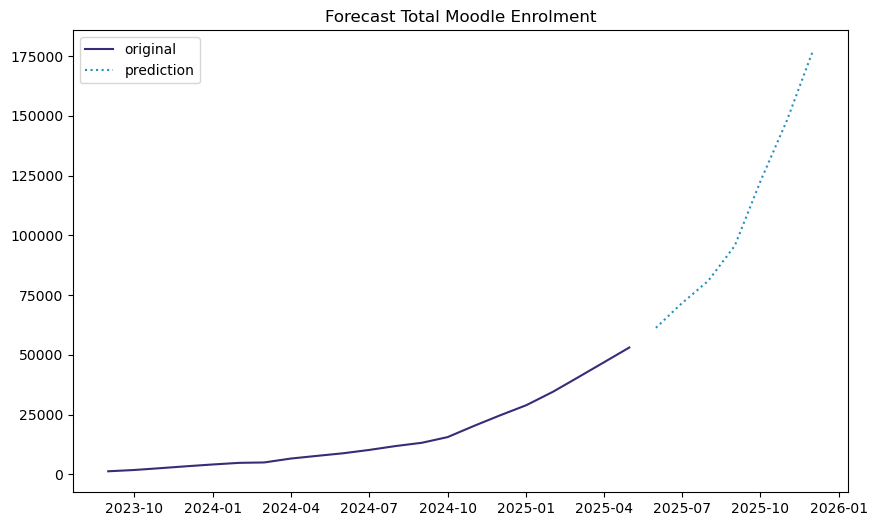

<Axes: xlabel='Date'>

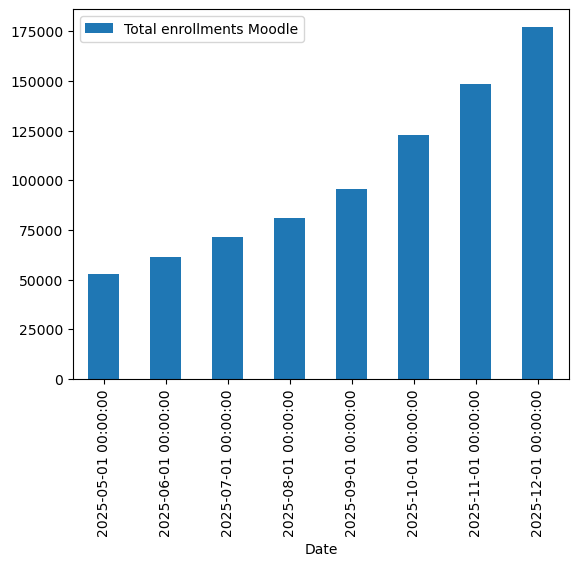

In [43]:
# Total enrollments Moodle
for d in pred_moving_average['date']:    
    ma_total_enrolments_moodle = ma_total_enrolments_moodle.asfreq('MS')
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_total_enrolments_moodle['Total enrollments Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_total_enrolments_moodle['Total enrollments Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_total_enrolments_moodle['Total enrollments Moodle'], d, span = 1, w1 = 0.6, w2 = 0.4)
    ma_total_enrolments_moodle.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_total_enrolments_moodle.loc['2025-05-01' :])

plot_forecast(ma_total_enrolments_moodle.loc[: '2025-05-01'], ma_total_enrolments_moodle.loc['2025-06-01' :], 'Forecast Total Moodle Enrolment')

ma_total_enrolments_moodle.loc['2025-05-01' :].plot.bar()

              CoP Moodle
Date                    
2025-05-01   8574.000000
2025-06-01  10115.399890
2025-07-01  11934.459157
2025-08-01  13989.389333
2025-09-01  16164.892054
2025-10-01  20083.331181
2025-11-01  24888.553174
2025-12-01  31799.247866


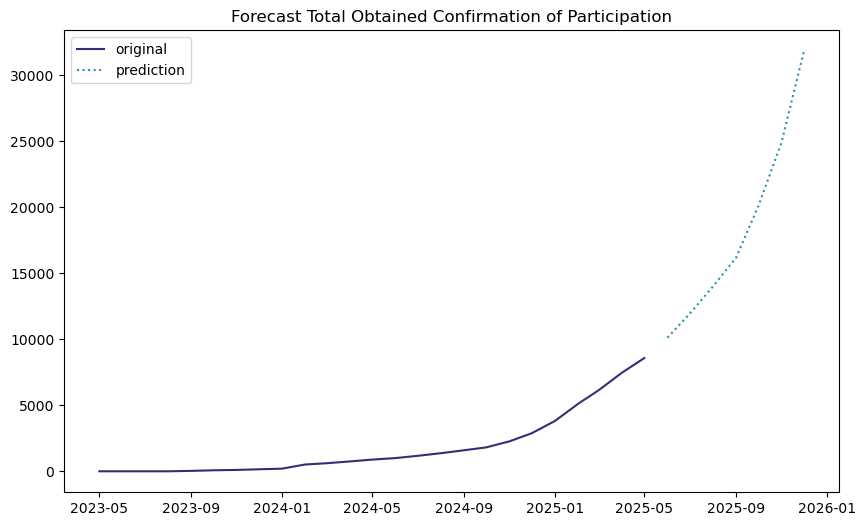

<Axes: xlabel='Date'>

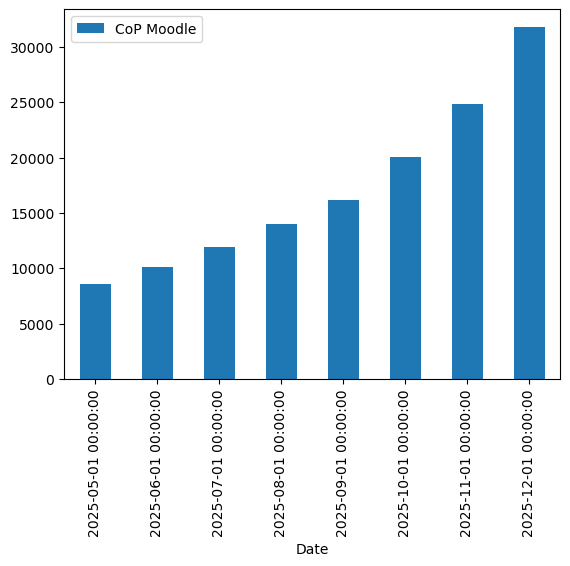

In [44]:
# CoP Moodle

for d in pred_moving_average['date']:    
    ma_cop_moodle = ma_cop_moodle.asfreq('MS')
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_cop_moodle['CoP Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_cop_moodle['CoP Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_cop_moodle['CoP Moodle'], d, span = 1, w1 = 0.6, w2 = 0.4)
    ma_cop_moodle.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_cop_moodle.loc['2025-05-01' :])

plot_forecast(ma_cop_moodle.loc[: '2025-05-01'], ma_cop_moodle.loc['2025-06-01' :], 'Forecast Total Obtained Confirmation of Participation')

ma_cop_moodle.loc['2025-05-01' :].plot.bar()


              RoA Moodle
Date                    
2025-05-01   6231.000000
2025-06-01   7422.478079
2025-07-01   8713.238801
2025-08-01  10168.016879
2025-09-01  11759.135934
2025-10-01  14552.281835
2025-11-01  17672.570865
2025-12-01  22552.396107


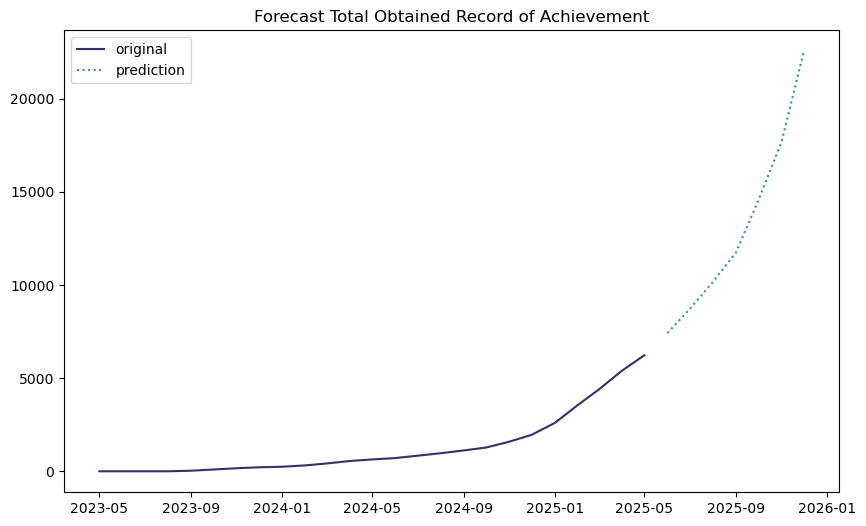

<Axes: xlabel='Date'>

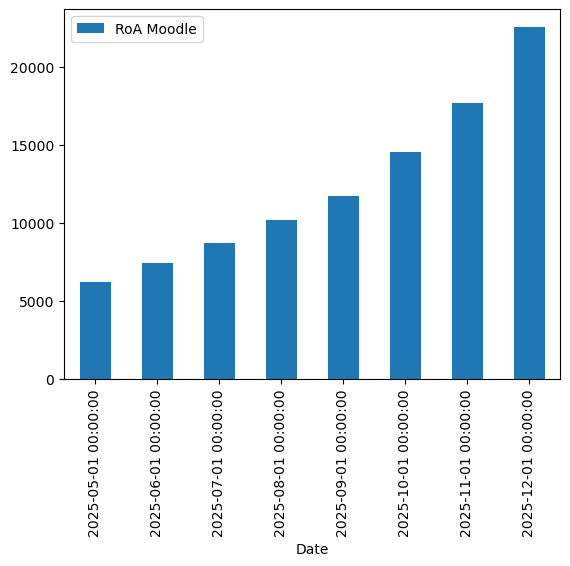

In [45]:
# RoA Moodle
for d in pred_moving_average['date']:    
    ma_roa_moodle = ma_roa_moodle.asfreq('MS')
    if datetime.strptime(d,'%Y-%m-%d').month in [4, 10]:
        predictions = moving_average(ma_roa_moodle['RoA Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    elif datetime.strptime(d,'%Y-%m-%d').month in [7, 8, 9, 2, 3]:
        predictions = moving_average(ma_roa_moodle['RoA Moodle'], d, span = 1, w1 = 0.8, w2 = 0.25)
    else: 
        predictions = moving_average(ma_roa_moodle['RoA Moodle'], d, span = 1, w1 = 0.6, w2 = 0.4)
    ma_roa_moodle.loc[datetime.strptime(d,'%Y-%m-%d')] = predictions
    
print(ma_roa_moodle.loc['2025-05-01' :])

plot_forecast(ma_roa_moodle.loc[: '2025-05-01'], ma_roa_moodle.loc['2025-06-01' :], 'Forecast Total Obtained Record of Achievement')

ma_roa_moodle.loc['2025-05-01' :].plot.bar()